In [52]:
import pandas as pd
import numpy as np

# Read irradiance data
path = "data/raw/irradiance-from-site.csv"
df_raw = pd.read_csv(path)

# Parse "Site Time" to datetime
df_raw["Site Time"] = pd.to_datetime(df_raw["Site Time"])

# Extract hour-of-day (0-23) and day-of-year (1-365)
df_raw["hour_of_day"] = df_raw["Site Time"].dt.hour + df_raw["Site Time"].dt.minute / 60.0
df_raw["day_of_year"] = df_raw["Site Time"].dt.dayofyear

# Cyclic encoding: sin and cos so 0 and 24h (or day 1 and 365) are close
# Hour: period 24
df_raw["hour_sin"] = np.sin(2 * np.pi * df_raw["hour_of_day"] / 24)
df_raw["hour_cos"] = np.cos(2 * np.pi * df_raw["hour_of_day"] / 24)
# Day of year: period 365
df_raw["day_sin"] = np.sin(2 * np.pi * df_raw["day_of_year"] / 365)
df_raw["day_cos"] = np.cos(2 * np.pi * df_raw["day_of_year"] / 365)

# Build training dataframe: label = Irradiance - bottom, features = Irradiance - top + cyclic time
df = pd.DataFrame({
    "datetime": df_raw["Site Time"],
    "Irradiance - top": df_raw["Irradiance - top"],
    "hour_sin": df_raw["hour_sin"],
    "hour_cos": df_raw["hour_cos"],
    "day_sin": df_raw["day_sin"],
    "day_cos": df_raw["day_cos"],
    "Irradiance - bottom": df_raw["Irradiance - bottom"],
})

print("Shape:", df.shape)
print("\nFirst rows:")
print(df.head(10))
print("\nColumn dtypes:")
print(df.dtypes)
print("\nSummary:")
print(df.describe())

Shape: (23328, 7)

First rows:
             datetime  Irradiance - top  hour_sin  hour_cos   day_sin  \
0 2025-08-12 00:00:00              -8.0  0.000000  1.000000 -0.655156   
1 2025-08-12 00:05:00              -1.0  0.021815  0.999762 -0.655156   
2 2025-08-12 00:10:00               0.0  0.043619  0.999048 -0.655156   
3 2025-08-12 00:15:00             -14.0  0.065403  0.997859 -0.655156   
4 2025-08-12 00:20:00             -10.0  0.087156  0.996195 -0.655156   
5 2025-08-12 00:25:00              -8.0  0.108867  0.994056 -0.655156   
6 2025-08-12 00:30:00              -8.0  0.130526  0.991445 -0.655156   
7 2025-08-12 00:35:00             -12.0  0.152123  0.988362 -0.655156   
8 2025-08-12 00:40:00               1.0  0.173648  0.984808 -0.655156   
9 2025-08-12 00:45:00               0.0  0.195090  0.980785 -0.655156   

    day_cos  Irradiance - bottom  
0 -0.755493                  0.0  
1 -0.755493                  0.0  
2 -0.755493                  0.0  
3 -0.755493              

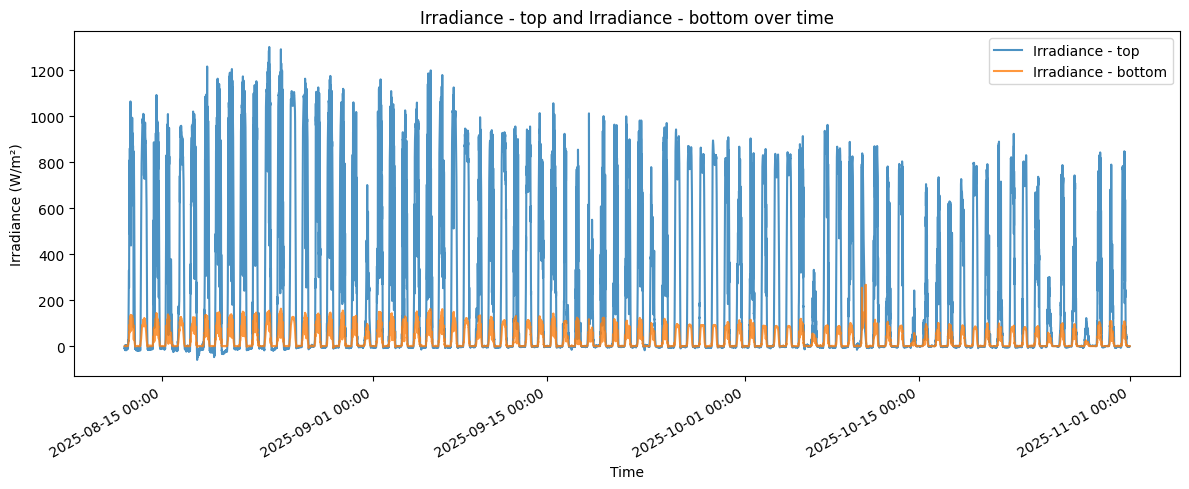

In [53]:
# Time series: Irradiance - top and Irradiance - bottom over time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_plot = df.dropna(subset=["Irradiance - top", "Irradiance - bottom"]).copy()
df_plot["datetime"] = pd.to_datetime(df_plot["datetime"])

plt.figure(figsize=(12, 5))
plt.plot(df_plot["datetime"], df_plot["Irradiance - top"], label="Irradiance - top", alpha=0.8)
plt.plot(df_plot["datetime"], df_plot["Irradiance - bottom"], label="Irradiance - bottom", alpha=0.8)
plt.xlabel("Time")
plt.ylabel("Irradiance (W/m²)")
plt.title("Irradiance - top and Irradiance - bottom over time")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Feature matrix and label
feature_cols = ["Irradiance - top", "hour_sin", "hour_cos", "day_sin", "day_cos"]
label_col = "Irradiance - bottom"

# Drop rows with NaN in features or label, then split into train / validation / test (before scaling)
df_clean = df.dropna(subset=feature_cols + [label_col])
X_raw = df_clean[feature_cols].values
y_raw = df_clean[label_col].values

# First: 80% train+val, 20% test
X_trainval_raw, X_test_raw, y_trainval_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)
# Second: split train+val into 80% train, 20% validation
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_trainval_raw, y_trainval_raw, test_size=0.2, random_state=42
)

# Fit scalers on training data only; then transform train, validation, and test
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_raw)
X_val = scaler_X.transform(X_val_raw)
X_test = scaler_X.transform(X_test_raw)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val_raw.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()

print("Train size: %d  |  Val size: %d  |  Test size: %d" % (len(y_train), len(y_val), len(y_test)))
print("Features (standardized):", feature_cols)
print("Label (standardized):", label_col)
print("X_train shape:", X_train.shape, "  X_val shape:", X_val.shape, "  X_test shape:", X_test.shape)
print("\nScaled X_train - mean:", X_train.mean(axis=0).round(6), "std:", X_train.std(axis=0).round(6))
print("Scaled y_train - mean: %.6f  std: %.6f" % (y_train.mean(), y_train.std()))

Train size: 14879  |  Val size: 3720  |  Test size: 4650
Features (standardized): ['Irradiance - top', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
Label (standardized): Irradiance - bottom
X_train shape: (14879, 5)   X_val shape: (3720, 5)   X_test shape: (4650, 5)

Scaled X_train - mean: [-0. -0. -0.  0. -0.] std: [1. 1. 1. 1. 1.]
Scaled y_train - mean: 0.000000  std: 1.000000


In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Build MLP: 5 inputs (Irradiance - top + time features) -> hidden layers -> 1 output (Irradiance - bottom)
model = keras.Sequential([
    layers.Dense(64, activation="tanh", input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation="tanh"),
    layers.Dense(16, activation="tanh"),
    layers.Dense(1),
])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

c:\Users\nhphuong\Desktop\Solar\all_data\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Early stopping: stop when val_loss stops improving, restore best weights
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

# Train with validation set and early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/100


233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1315 - mae: 0.2049 - val_loss: 0.1148 - val_mae: 0.1516
Epoch 2/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 0.0801 - mae: 0.1398 - val_loss: 0.1016 - val_mae: 0.1312
Epoch 3/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0733 - mae: 0.1278 - val_loss: 0.0972 - val_mae: 0.1268
Epoch 4/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.0661 - mae: 0.1112 - val_loss: 0.0894 - val_mae: 0.1029
Epoch 5/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.0626 - mae: 0.1042 - val_loss: 0.0900 - val_mae: 0.1039
Epoch 6/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.0594 - mae: 0.0981 - val_loss: 0.0850 - val_mae: 0.0943
Epoch 7/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.0594 - mae: 0.0997 - val_loss: 0.0844 - val_mae: 0.0865
Epoch 8/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.0577 - mae: 0.0941 - val_loss: 0.0836 - val_mae: 0.0885
Epoch 9/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 86

In [57]:
# Predict on test set, then inverse transform to original irradiance units
y_pred_scaled = model.predict(X_test, verbose=0).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Metrics in original units (Irradiance - bottom)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
print("Test set (inverse-transformed to original units):")
print("  RMSE: %.4f" % rmse)
print("  MAE:  %.4f" % mae)
print("  R²:   %.4f" % r2)

Test set (inverse-transformed to original units):
  RMSE: 4.2615
  MAE:  2.5929
  R²:   0.9885


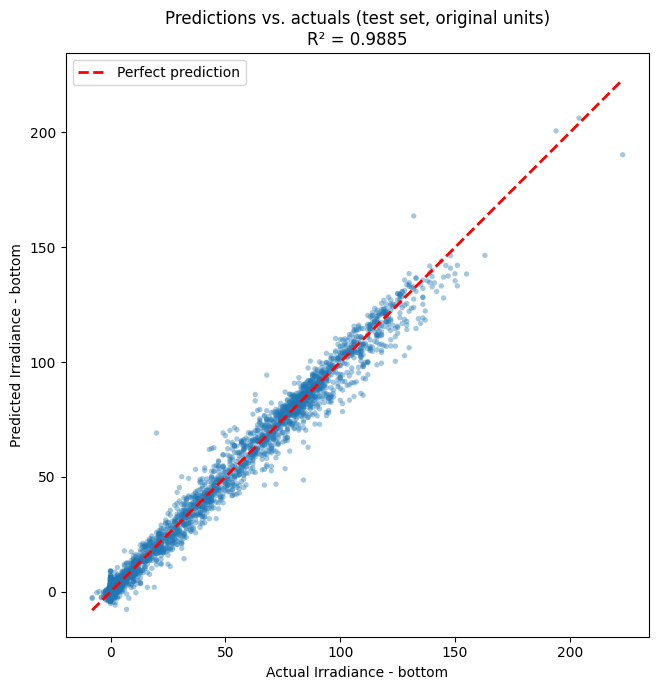

In [58]:
# Predictions vs. actuals (scatter plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(y_test_original, y_pred, alpha=0.4, s=15, edgecolors="none")
mn = min(y_test_original.min(), y_pred.min())
mx = max(y_test_original.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], "r--", lw=2, label="Perfect prediction")
plt.xlabel("Actual Irradiance - bottom")
plt.ylabel("Predicted Irradiance - bottom")
plt.title("Predictions vs. actuals (test set, original units)\nR² = %.4f" % r2)
plt.legend()
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

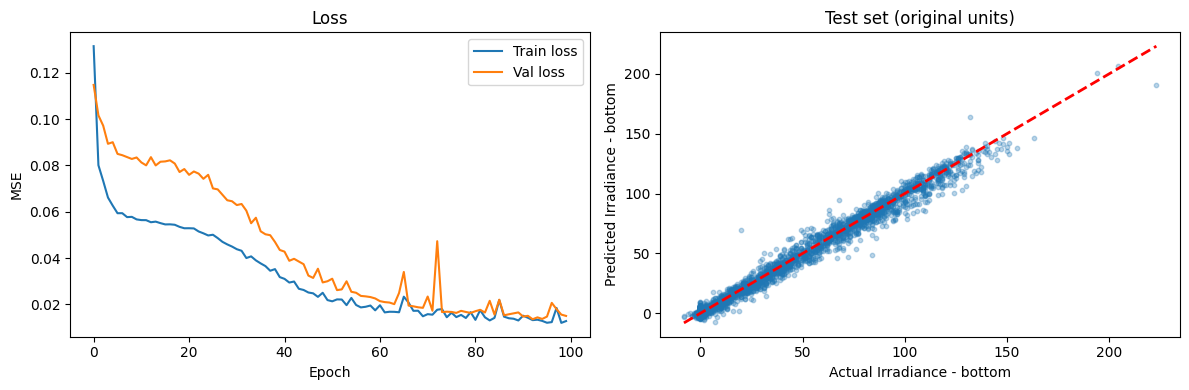

In [59]:
# Optional: plot training history and predictions vs actual (original units)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history["loss"], label="Train loss")
axes[0].plot(history.history["val_loss"], label="Val loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE")
axes[0].legend()
axes[0].set_title("Loss")

axes[1].scatter(y_test_original, y_pred, alpha=0.3, s=10)
axes[1].plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], "r--", lw=2)
axes[1].set_xlabel("Actual Irradiance - bottom")
axes[1].set_ylabel("Predicted Irradiance - bottom")
axes[1].set_title("Test set (original units)")
plt.tight_layout()
plt.show()

In [60]:
# --- Validate: is the neural network good? ---

# 1) Baseline: predict training mean (in original units)
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
baseline_pred = np.full_like(y_test_original, y_train_original.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test_original, baseline_pred))
baseline_r2 = r2_score(y_test_original, baseline_pred)
print("1. Baseline (predict train mean):")
print("   RMSE: %.4f   R²: %.4f" % (baseline_rmse, baseline_r2))
print("   Model RMSE: %.4f   Model R²: %.4f" % (rmse, r2))
print("   Model beats baseline: %s (lower RMSE, higher R²)" % (rmse < baseline_rmse and r2 > baseline_r2))

# 2) Overfitting: final train vs validation loss
final_train_loss = history.history["loss"][-1]
final_val_loss = history.history["val_loss"][-1]
print("\n2. Overfitting check (final epoch):")
print("   Train loss: %.6f   Val loss: %.6f" % (final_train_loss, final_val_loss))
print("   Val/Train ratio: %.2f (>>1 suggests overfitting)" % (final_val_loss / final_train_loss))

# 3) Residuals (original units)
residuals = y_test_original - y_pred
print("\n3. Residuals (actual - predicted, original units):")
print("   Mean: %.4f (should be ~0)   Std: %.4f" % (residuals.mean(), residuals.std()))

# 4) Verdict
is_good = (
    r2 > 0.2
    and rmse < baseline_rmse
    and final_val_loss / max(final_train_loss, 1e-8) < 2.0
)
print("\n4. Verdict: %s" % ("Model is GOOD (reasonable R², beats baseline, no severe overfitting)" if is_good else "Model needs improvement (low R², or does not beat baseline, or overfitting)"))

1. Baseline (predict train mean):
   RMSE: 39.7560   R²: -0.0001
   Model RMSE: 4.2615   Model R²: 0.9885
   Model beats baseline: True (lower RMSE, higher R²)

2. Overfitting check (final epoch):
   Train loss: 0.012753   Val loss: 0.014977
   Val/Train ratio: 1.17 (>>1 suggests overfitting)

3. Residuals (actual - predicted, original units):
   Mean: 0.1907 (should be ~0)   Std: 4.2573

4. Verdict: Model is GOOD (reasonable R², beats baseline, no severe overfitting)


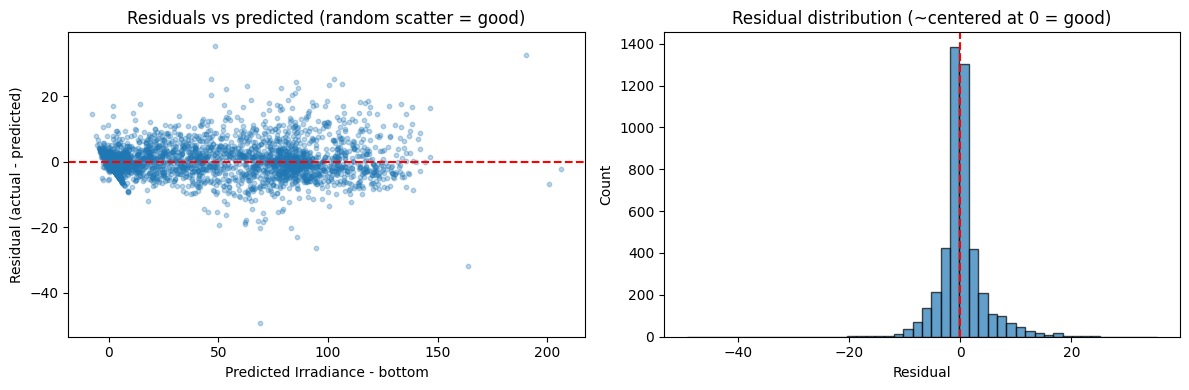

In [61]:
# Residual diagnostics (good model: random scatter, residuals centered ~0)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(y_pred, residuals, alpha=0.3, s=10)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Predicted Irradiance - bottom")
axes[0].set_ylabel("Residual (actual - predicted)")
axes[0].set_title("Residuals vs predicted (random scatter = good)")
axes[1].hist(residuals, bins=50, edgecolor="black", alpha=0.7)
axes[1].axvline(0, color="red", linestyle="--")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Count")
axes[1].set_title("Residual distribution (~centered at 0 = good)")
plt.tight_layout()
plt.show()

In [63]:
# Gradient of Irradiance - bottom w.r.t. each input feature (finite difference)
# Check 10 random points: baseline prediction -> perturb one feature by ε -> gradient ≈ Δoutput / Δinput

eps = 0.1
np.random.seed(42)
n_points = 100
random_indices = np.random.choice(len(X_test_raw), size=n_points, replace=False)

def compute_gradients_at_point(x_orig):
    """Compute gradients for all features at a given point."""
    x_scaled = scaler_X.transform(x_orig.reshape(1, -1))
    baseline_scaled = model.predict(x_scaled, verbose=0)
    baseline_pred = scaler_y.inverse_transform(baseline_scaled).flatten()[0]
    
    raw_deltas = []  # Δoutput = pred_perturb - baseline_pred (before division by ε)
    gradients = []
    for i in range(len(feature_cols)):
        x_perturb = x_orig.copy()
        x_perturb[i] += eps
        x_perturb_scaled = scaler_X.transform(x_perturb.reshape(1, -1))
        pred_perturb_scaled = model.predict(x_perturb_scaled, verbose=0)
        pred_perturb = scaler_y.inverse_transform(pred_perturb_scaled).flatten()[0]
        delta_output = pred_perturb - baseline_pred
        raw_deltas.append(delta_output)
        grad = delta_output / eps
        gradients.append(grad)
    return baseline_pred, raw_deltas, gradients

# Compute gradients for each random point
all_gradients = []
print_per_point_details = 2  # print full details for first N points (0 = none)
for k, idx in enumerate(random_indices, 1):
    x_orig = X_test_raw[idx].copy()
    baseline_pred, raw_deltas, gradients = compute_gradients_at_point(x_orig)
    all_gradients.append(gradients)
    if print_per_point_details and k <= print_per_point_details:
        print("=" * 70)
        print("Point %d/%d (test row index %d):" % (k, n_points, idx))
        for i, name in enumerate(feature_cols):
            print("  %s = %.6g" % (name, x_orig[i]))
        print("  Baseline prediction (Irradiance - bottom): %.4f" % baseline_pred)
        print("  Raw values before division (Δoutput, ε, then gradient = Δoutput/ε):")
        for i, name in enumerate(feature_cols):
            print("    %s: Δoutput = %.6g, ε = %.0e, gradient = %.6g" % (name, raw_deltas[i], eps, gradients[i]))
if n_points > print_per_point_details and print_per_point_details > 0:
    print("... (%d more points, summary below)" % (n_points - print_per_point_details))

# Summary: average gradients across all 10 points
all_gradients = np.array(all_gradients)
mean_gradients = all_gradients.mean(axis=0)
std_gradients = all_gradients.std(axis=0)

print("\n" + "=" * 70)
print("SUMMARY: Average gradients across %d random points:" % n_points)
for i, name in enumerate(feature_cols):
    print("  d(Irradiance_bottom) / d(%s): mean = %.6g, std = %.6g" % (name, mean_gradients[i], std_gradients[i]))
print("\nInterpretation: e.g. if d(bottom)/d(top)=0.5, increasing Irradiance - top by 1 W/m² changes Irradiance - bottom by ~0.5 W/m² on average.")

Point 1/100 (test row index 1705):
  Irradiance - top = -5
  hour_sin = 0.737277
  hour_cos = 0.67559
  day_sin = -0.668064
  day_cos = -0.744104
  Baseline prediction (Irradiance - bottom): 1.6959
  Raw values before division (Δoutput, ε, then gradient = Δoutput/ε):
    Irradiance - top: Δoutput = 0.00354958, ε = 1e-01, gradient = 0.0354958
    hour_sin: Δoutput = 1.26577, ε = 1e-01, gradient = 12.6577
    hour_cos: Δoutput = 2.71745, ε = 1e-01, gradient = 27.1745
    day_sin: Δoutput = 0.0219173, ε = 1e-01, gradient = 0.219173
    day_cos: Δoutput = 4.83796, ε = 1e-01, gradient = 48.3796
Point 2/100 (test row index 354):
  Irradiance - top = 34
  hour_sin = 0.866025
  hour_cos = -0.5
  day_sin = -0.826354
  day_cos = -0.563151
  Baseline prediction (Irradiance - bottom): 9.8409
  Raw values before division (Δoutput, ε, then gradient = Δoutput/ε):
    Irradiance - top: Δoutput = 0.0165062, ε = 1e-01, gradient = 0.165062
    hour_sin: Δoutput = 3.06634, ε = 1e-01, gradient = 30.6634
  